# Training in Brax

In [Brax Environments](https://colab.research.google.com/github/google/brax/blob/main/notebooks/environments.ipynb) we learned about creating environments and using them to quickly generate rollouts. We can learn all kinds of fun and useful behaviors on those environments via Brax's built-in training algorithms.

Let's try them out!

In [1]:
!pip install --upgrade git+https://github.com/google/brax.git@main

  Cloning https://github.com/google/brax.git (to revision main) to /tmp/pip-req-build-mbnfgwuu
  Running command git clone -q https://github.com/google/brax.git /tmp/pip-req-build-mbnfgwuu


In [1]:
#@title Install Brax and some helper modules
#@markdown ## ⚠️ PLEASE NOTE:
#@markdown This colab runs best using a TPU runtime.  From the Colab menu, choose Runtime > Change Runtime Type, then select **'TPU'** in the dropdown.

from datetime import datetime
import functools
import os

from IPython.display import HTML, clear_output

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

try:
  import brax
except ImportError:
  !pip install --upgrade git+https://github.com/google/brax.git@main
  clear_output()
  import brax

from brax import envs
from brax import jumpy as jp
from brax.training import ppo, sac
from brax.io import html
from brax.io import model

if 'COLAB_TPU_ADDR' in os.environ:
  from jax.tools import colab_tpu
  colab_tpu.setup_tpu()

In [2]:

from typing import Tuple

import brax
from brax import jumpy as jp
from brax import math
from brax.envs import env as E


class PointMass(E.Env):
  """Controllable ball, optionally objects have target locations. 
  """

  def __init__(self, **kwargs):
    super().__init__(_SYSTEM_CONFIG, **kwargs)
    self.object_idx = self.sys.body.index['Object']
    self.target_idx = self.sys.body.index['Target']
    # self.box_idx = self.sys.body.index['Box1']
    # self.box_idx2 = self.sys.body.index['Box2']
    self.palm_idx = self.sys.body.index['HandPalm']
    self.target_radius = 1.1
    self.target_distance = 10.
    self.target_height = 8.

    # map the [-1, 1] action space into a valid angle for the actuators
    limits = []
    # for j in self.sys.config.joints:
    #   for l in j.angle_limit:
    #     limits.append((l.min, l.max))
    self._min_act = jp.array([l[0] for l in limits])
    self._range_act = jp.array([l[1] - l[0] for l in limits])

    # add limits for the translational motion of the hand base
    self._min_act = jp.concatenate([self._min_act, jp.array([-10, -10, 3.5])])
    self._range_act = jp.concatenate([self._range_act, jp.array([20, 20, 10])])

  def reset(self, rng: jp.ndarray) -> E.State:
    qp = self.sys.default_qp()

    palm_pos =jnp.array([0,0,1])
    object_pos =jnp.array([0.0,0,3])
    # box_pos = jnp.array([0.0,-5,2])
    # box_pos2 = jnp.array([0.0,-10,2])
    pos = qp.pos
    pos = jp.index_update(pos, self.palm_idx, palm_pos)
    pos = jp.index_update(pos, self.object_idx, object_pos)
    # pos = jp.index_update(pos, self.box_idx, box_pos)
    # pos = jp.index_update(pos, self.box_idx2, box_pos2)
    qp = qp.replace(pos=pos, vel= jnp.zeros_like(qp.vel))

    # rng, target = self._random_target(rng)
    # pos = qp.pos.at[self.target_idx].set(target)
    # qp = dataclasses.replace(qp, pos=pos)
    info = self.sys.info(qp)
    obs = self._get_obs(qp, info)
    reward, done, zero = jp.zeros(3)
    metrics = {
        'hits': zero,
        'touchingObject': zero,
        'movingToObject': zero,
        'movingObjectToTarget': zero,
        'closeToObject': zero
    }
    info = {'rng': rng}
    return E.State(qp, obs, reward, done, metrics, info)

  def step(self, state: E.State, action: jp.ndarray) -> E.State:
    # actuate the palm
    # action = self._min_act + self._range_act * ((action + 1) / 2.)
    # target_pos = action[-3:]
    # palm_pos = state.qp.pos[self.palm_idx]
    # norm = jp.norm(target_pos - palm_pos)
    # # make sure hand doesn't move too fast
    # scale = jp.where(norm > 2.0, 2. / norm, 1.0)
    # palm_pos = palm_pos + scale * (target_pos - palm_pos) * .15
    # pos = state.qp.pos
    # pos = jp.index_update(pos, self.palm_idx, palm_pos)
    # qp = state.qp.replace(pos=pos)

    vel = state.qp.vel
    vel = jp.index_update(vel, self.palm_idx, action[-3:])
    qp = state.qp.replace(vel= vel)

    # do the rest of the physics update
    qp, info = self.sys.step(qp, action)
    obs = self._get_obs(qp, info)

    # small reward for moving in right direction
    object_pos = qp.pos[self.object_idx]
    hand_pos = qp.pos[self.palm_idx]
    hand_vel = qp.vel[self.palm_idx]
    object_rel = object_pos - hand_pos
    object_dist = jp.norm(object_rel)
    planar_object_dist = jp.norm(object_rel * jp.array([1., 1., 0.]))
    object_dir = object_rel / (1e-6 + object_dist.reshape(-1))

    moving_to_object = .1 * self.sys.config.dt * jp.dot(hand_vel, object_dir)
    close_to_object = .1 * self.sys.config.dt * 1. / (1. + planar_object_dist)

    # large reward for object moving to target
    target_pos = qp.pos[self.target_idx]
    object_vel = qp.vel[self.object_idx]
    target_rel = target_pos - object_pos

    target_dist = jp.norm(target_rel)
    target_dir = target_rel / (1e-6 + target_dist)
    moving_to_target = 1.5 * self.sys.config.dt * jp.dot(
        object_vel, target_dir)

    # small reward for touching object
    contact_mag = jp.sum(jp.square(info.contact.vel), axis=-1)
    contacts = jp.where(contact_mag > 0.00001, 1, 0)
    # touching_object = 0.2 * self.sys.config.dt * (
    #     contacts[3] + contacts[9] + contacts[12] + contacts[15])

    # big reward for reaching target
    target_hit = jp.where(target_dist < self.target_radius, 1.0, 0.0)

    reward = moving_to_object + close_to_object + 5. * target_hit + moving_to_target

    state.metrics.update(
        hits=target_hit,
        movingToObject=moving_to_object,
        movingObjectToTarget=moving_to_target,
        closeToObject=close_to_object)

    # teleport any hit targets
    rng, target = self._random_target(state.info['rng'])
    target = jp.where(target_hit, target, qp.pos[self.target_idx])
    pos = jp.index_update(qp.pos, self.target_idx, target)
    qp = qp.replace(pos=pos)
    state.info.update(rng=rng)
    return state.replace(qp=qp, obs=obs, reward=reward)

  @property
  def action_size(self) -> int:
    return super().action_size + 3  # 3 extra actions for translating

  def _get_obs(self, qp: brax.QP, info: brax.Info) -> jp.ndarray:
    """Egocentric observation of target, object, and hand."""

    v_inv_rotate = jp.vmap(math.inv_rotate, include=(True, False))

    pos_local = qp.pos - qp.pos[self.palm_idx]
    pos_local = v_inv_rotate(pos_local, qp.rot[self.palm_idx])
    vel_local = v_inv_rotate(qp.vel, qp.rot[self.palm_idx])

    object_local = pos_local[self.object_idx]
    object_local_mag = jp.norm(object_local).reshape(-1)
    object_local_dir = object_local / (1e-6 + object_local_mag)

    # target specific obs
    hand_to_obj = qp.pos[self.object_idx] - qp.pos[self.palm_idx]
    hand_to_obj_mag = jp.norm(hand_to_obj)
    hand_to_obj_dir = hand_to_obj / (1e-6 + hand_to_obj_mag)
    hand_vel = qp.vel[self.palm_idx]
    heading_to_obj = jp.dot(hand_to_obj_dir, hand_vel).reshape(-1)

    target_local = pos_local[self.target_idx]
    target_local_mag = jp.norm(target_local).reshape(-1)
    target_local_dir = target_local / (1e-6 + target_local_mag)

    # object to target
    obj_to_target = qp.pos[self.target_idx] - qp.pos[self.object_idx]
    obj_to_target_mag = jp.norm(obj_to_target).reshape(-1)
    obj_to_target_dir = obj_to_target / (1e-6 + obj_to_target_mag)

    object_vel = qp.vel[self.object_idx]
    obj_heading_to_target = jp.dot(obj_to_target_dir, object_vel).reshape(-1)

    pos_local = pos_local.reshape(-1)
    vel_local = vel_local.reshape(-1)

    contact_mag = jp.sum(jp.square(info.contact.vel), axis=-1)
    contacts = jp.where(contact_mag > 0.00001, 1, 0)

    return jp.concatenate([
        object_local_mag, object_local_dir, target_local_mag, target_local_dir,
        pos_local, vel_local, hand_to_obj, hand_vel, heading_to_obj,
        obj_to_target_mag, obj_to_target_dir, obj_heading_to_target, contacts
    ])

  def _random_target(self, rng: jp.ndarray) -> Tuple[jp.ndarray, jp.ndarray]:
    """Returns new random target locations in a random circle on xz plane."""
    rng, rng1, rng2, rng3 = jp.random_split(rng, 4)
    dist = self.target_radius + self.target_distance * jp.random_uniform(rng1)
    ang = jp.pi * 2. * jp.random_uniform(rng2)
    target_x = dist * jp.cos(ang)
    target_y = dist * jp.sin(ang)
    target_z = self.target_height * jp.random_uniform(rng3)
    target = jp.array([target_x, target_y, target_z]).transpose()
    return rng, target


_SYSTEM_CONFIG = """
bodies {
  name: "Ground"
  colliders {
    plane {
    }
  }
  inertia {
    x: 1.0
    y: 1.0
    z: 1.0
  }
  mass: 1.0
  frozen { all: true }
}
bodies {
  name: "Object"
  colliders {
    capsule {
      radius: 1.0
      length: 2.0
    }
    rotation { x: 90 }
  }
  inertia {
    x: 1.0
    y: 1.0
    z: 1.0
  }
  mass: 1.0
}
bodies {
  name: "HandPalm"
  colliders {
    capsule {
      radius: 1.5
      length: 3.0
    }
    rotation { x: 120 }
  }
  inertia {
    x: 1.0350000858306885
    y: 1.7224998474121094
    z: 1.7224998474121094
  }
  mass: 1.0
}
bodies {
  name: "Target"
  colliders { sphere { radius: 1.1 }}
  frozen { all: true }
}
friction: 0.77459666924
gravity {
  z: -9.800000190734863
}
angular_damping: -0.05000000074505806
baumgarte_erp: 0.15000000149011612
collide_include {
  first: "Ground"
  second: "Object"
}
collide_include {
  first: "Ground"
  second: "Box1"
}
collide_include {
  first: "HandPalm"
  second: "Object"
}

dt: 0.02
substeps: 4
"""

In [3]:
# friction: .1
# gravity { z: -9.8 }
# angular_damping: 0.00
# baumgarte_erp: 0.01
# elasticity: 0.9
# dt: 0.0167
# substeps: 240

In [4]:
import functools
from typing import Callable, Optional, Union, overload
from brax.envs.env import Env, State, Wrapper
from brax.envs import grasp
from brax.envs import wrappers

_envs = {
    'exp': PointMass,
}


def create(env_name: str,
           episode_length: int = 1000,
           action_repeat: int = 1,
           auto_reset: bool = True,
           batch_size: Optional[int] = None,
           eval_metrics: bool = False,
           **kwargs) -> Env:
  """Creates an Env with a specified brax system."""
  env = _envs[env_name](**kwargs)
  if episode_length is not None:
    env = wrappers.EpisodeWrapper(env, episode_length, action_repeat)
  if batch_size:
    env = wrappers.VectorWrapper(env, batch_size)
  if auto_reset:
    env = wrappers.AutoResetWrapper(env)
  if eval_metrics:
    env = wrappers.EvalWrapper(env)

  return env  # type: ignore


def create_fn(env_name: str, **kwargs) -> Callable[..., Env]:
  """Returns a function that when called, creates an Env."""
  return functools.partial(create, env_name, **kwargs)

First let's pick an environment to train an agent:

In [5]:
#@title Preview a Brax environment { run: "auto" }
#@markdown Select the environment to train:

env_name = "exp" 
env_fn = create_fn(env_name=env_name)
env = env_fn()

In [6]:

state = env.reset(rng=jp.random_prngkey(seed=0))

HTML(html.render(env.sys, [state.qp]))

In [7]:
jit_env_reset = jax.jit(env.reset)
jit_env_step = jax.jit(env.step)
rollout = []

In [8]:
# rng = jax.random.PRNGKey(seed=0)
from brax import jumpy as jp
state = env.reset(rng=jp.random_prngkey(seed=0))

In [9]:
act = jnp.array([-0.0,-5,0])
for i in range(0,800):
  rollout.append(state)
  # act = -jnp.ones((env.action_size))
  state = jit_env_step(state, act)

HTML(html.render(env.sys, [s.qp for s in rollout]))

# Ray tracing time!

Naive first (for loops!), then manually vectorised, then idiomatic vmap.

Here is a simple test that we can render an image.

In [10]:
import matplotlib.pyplot as plt
import flax
from jax import vmap
# pixels written in rows l>r
# writen top to bottom

In [11]:
%%time
@jax.jit
def render_image(image_height= 64, image_width=64):

  rows = []
  for j in reversed(range(0, image_height)):
    row = []
    for i in range(0, image_width):
      r = i / (image_width-1)
      g = j / (image_height-1)
      b = 0.25 
      row.append([r,g,b])
    rows.append(row)

  return jnp.array(rows)

CPU times: user 327 µs, sys: 0 ns, total: 327 µs
Wall time: 213 µs


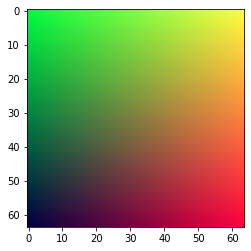

In [12]:
plt.imshow(render_image())

As expected, directly porting the C++ code is extraordinarily slow, its basically impossible to render anything meaningful. We can reduce the time required by factors of > M by jit-ing and vectorising

In [13]:
class ray:
  def __init__(self, origin, direction):
    self.origin = origin
    self.direction = direction

  def at(t):
    return self.origin + t*self.direction


def ray_color(r):
  unit_direction = r.direction / jnp.linalg.norm(r.direction)
  t = 0.5*(unit_direction[1] + 1.0)
  return (1.0-t) * jnp.array([1.0,1.0,1.0]) + t*jnp.array([0.5, 0.7, 1.0])



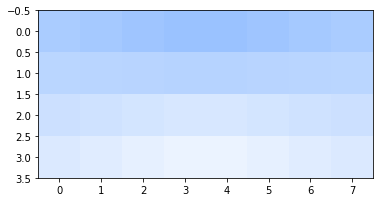

In [14]:

# Image
aspect_ratio = 16.0/9.0
image_width = 8
image_height = image_width / aspect_ratio
#Camera
viewport_height = 2.0
viewport_width = aspect_ratio * viewport_height
focal_length = 1.0
origin = jnp.array([0,0,0])
horizontal = jnp.array([viewport_width, 0,0])
vertical = jnp.array([0, viewport_height, 0])
lower_left_corner = origin - horizontal / 2 - vertical /2 - jnp.array([0,0,focal_length])

# @jax.jit
def render_image():

  rows = []
  for j in reversed(range(0, int(image_height))):
    row = []
    for i in range(0, int(image_width)):
      u = i / (image_width-1)
      v = j / (image_height-1)
      r = ray(origin, lower_left_corner+u*horizontal + v*vertical - origin)
      row.append(ray_color(r))
    rows.append(row)

  return jnp.array(rows)

plt.imshow(render_image())

Establish some new defaults, and do a simple vectorised calculation.

In [15]:
%%time
# Image
aspect_ratio = 16.0/9.0
image_width = 200
image_height = image_width / aspect_ratio
#Camera
viewport_height = 2.0
viewport_width = aspect_ratio * viewport_height
focal_length = 1.0
origin = jnp.array([[0,0,0]])
horizontal = jnp.array([viewport_width, 0,0])
vertical = jnp.array([0, viewport_height, 0])
lower_left_corner = origin - horizontal / 2 - vertical /2 - jnp.array([0,0,focal_length])

# create the range of u and v values
u = jnp.arange(0, image_width, 1) / (image_width-1)
v = jnp.arange(0, jnp.array(image_height, int), 1)[::-1] / (image_height-1) # maybe remove the int() - it makes it identical to guide but doesn't give 01 range
# construct a grid from them, and stretch it into two 1D vectos so that we have a long list of u,v points
u, v = jnp.meshgrid(u,v)
u, v = u.reshape([-1]), v.reshape([-1])

uv = jnp.vstack([u,v]).T # [N,2] - pixel coords

# multiply each u component with horizontal, and v compoent with vertical. 
viewport_hv = jnp.vstack([horizontal, vertical])
direction = lower_left_corner + uv @ viewport_hv - origin
# compute unit directions by dividing by norm
unit_direction = direction / jnp.linalg.norm(direction, axis=-1)[:, jnp.newaxis]

image_shape = jnp.array([jnp.array(image_height, int), image_width, 3])

CPU times: user 343 ms, sys: 372 ms, total: 715 ms
Wall time: 1.07 s


In [16]:
@jax.jit
def test_color(unit_direction):# make a blue fade based on y coordinate just to check it is all working
    t = 0.5*((unit_direction[:, 1]) +1.0)[:, jnp.newaxis] # [N,1]
    colors = (1-t) * jnp.array([[1.0,1.0,1.0]]) + t*jnp.array([[0.5, 0.7, 1.0]]) # [N,1] @ [1, 3] + [N,1] @ [1,3] -> [N,3]
    image = jnp.reshape(colors, image_shape)
    return image

In [17]:
%%time
image = test_color(unit_direction)

CPU times: user 50.8 ms, sys: 57.3 ms, total: 108 ms
Wall time: 144 ms


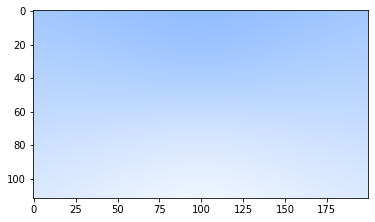

In [18]:
plt.imshow(image)

What if we'd like to show a sphere? This is where it gets a little more complicated - but lets walk through it. 

This is hand vectorised code to a degree that it is not idiomatic jax - but I wanted to see whether there was a speed difference. As you'll see later, there isn't - so we'll progress with liberal use of vmap.

The stages are:
- Get the disciminant and roots of every ray with every circle
- Create a mask of valid intersections which are within our FOV
- Find the closest solution (i.e, the intersection on this side of a given sphere), this will require correcting the solutions by adding (2*max +1) to any invalid (but potentially closer) solutions
- Include background as a potential object to hit in the solutions and colors matrix
- Calculate the specific color depending on ray angle
- Calculate colors for each pixel by summing across objects and masking any objects not hit

In [19]:
min_ray = 0.01 # don't render anything closer than 0.01m 
max_ray = 1000 # or further than 1000m

# make some spheres
spheres = jnp.array([[0,0.0,-1], [0,-100.5,-1.0]]) # [O, 3]
sphere_colors = jnp.array([[1.0, 0, 0], [0,1,1]]) # [O, 3]
radii = jnp.array([[0.5], [100]]) # [O, 1]

N = len(direction)
O = len(spheres)

valid_background = jnp.ones([1,N]) # the background is always valid
valid_background_dist = valid_background*max_ray # and always max dist away
background_color = jnp.array([[0, 1.0, 0]])
all_colors = jnp.concatenate([background_color, sphere_colors]) # [1+O, 3]

In [20]:
def discriminant_and_roots(sphere_origin, radius, ray_origin, direction):
    oc = ray_origin - sphere_origin # [1,3] - [O,3] - > [O,3]
    a = jnp.sum(direction * direction, -1) #[N, 3], [N,3] -> [N] 
    b = 2 * oc @ direction.T # [O,3] @ [3, N] -> [O,N]
    c = jnp.sum(oc * oc, -1)[:, jnp.newaxis] - radius * radius # [O,1]
    discriminant = b*b - (4*a*c) # [O, N]

    # to calculate the roots, we will relu discriminant
    # we do this becasue otherwise the sqrt will give us nans on negative discriminants
    # this is okay, because we will use the discriminant to mask out invalid intersections, so we don't care about wrong results in those entries
    sqrt_relu_discrim = jnp.sqrt(jax.nn.relu(discriminant)) # [O, N]

    r1 = (-b - sqrt_relu_discrim) / (2*a) # [O, N]
    r2 = (-b + sqrt_relu_discrim) / (2*a) # [O, N]

    return discriminant, r1, r2

@jax.jit
def get_pixels(spheres, radii, origin, direction):
  discrim, r1, r2 = discriminant_and_roots(spheres, radii, origin, direction)  # [O, N], [O, N], [O, N]
  # The discrim tells us if the ray intersects with the spheres
  hits = discrim >= 0 # [O, N]
  # The roots tell us if these intersections are in view
  r1_in_view = r1 > min_ray # [O, N]
  r2_in_view = r2 > min_ray # [O, N]
  # The and, or tells us if the hits are both valid, and one is in view.
  valid_hits = jnp.logical_and(hits, jnp.logical_or(r1_in_view, r2_in_view)) # [O, N]
  # Now, lets transform the roots so that invalid hits are 'further away' than the background, and thus won't get selected when we get the min
  solutions = jnp.concatenate([r1[jnp.newaxis, :,:], r2[jnp.newaxis, :, :]], 0) # [2, O, N]
  # Clip wrong solutions so they are at smallest -max_ray
  solutions = jnp.clip(solutions, a_min=-max_ray) # [2, O, N]
  # Small design decision here - we correct the solutions for the spheres here and collapse it into the closer solution
  # otherwise we'd need multiple dimensions for the other types of object/background
  # Add (2*max_ray + 1) to solutions where the hits are not valid, so that they are further than the background (which will be at max_ray)
  corrected_solutions = solutions + (2*max_ray+1) * jnp.logical_not(valid_hits) # [2, O, N]
  closer_solution = jnp.min(corrected_solutions, axis=0) # [O, N]
  # Now, we add the background (and in future other shapes such as triangles) to the hits and solutions array
  valid_solutions = jnp.concatenate([valid_background, valid_hits], axis=0) # [1+O, N]
  solutions = jnp.concatenate([valid_background_dist, closer_solution], axis = 0) # [1+O, N]
  # if the corrected solutions hadn't already been invalidated, would need to do here
  # chose the closest
  # one way of doing this would be argmin + onehot, but I think it might be faster to just do a mask of anything logical not above 
  # the min? Admittedly downstream we'll then have to divide these by the number of 'closest solutions (possible if the number
  # is exactly the same), and the color will be the average of those - but I think thats ok, if it is in exactly the same place
  # avg color kinda checks out? Lets test. 
  closest = jnp.logical_not(solutions > jnp.min(solutions, 0)) # [1+O, N]
  closest = closest / jnp.sum(closest, axis=0) # / number of solutions found at exactly the same distance

  # per ray background color
  background_t = 0.5*(unit_direction[:,1]+1)[:, jnp.newaxis] # [N,1]
  background_color = (1-background_t) @ jnp.array([[1.0,1.0,1.0]]) + background_t @ jnp.array([[0.5, 0.7, 1.0]]) # [N,3]
  # surface normals per sphere
  # p = A + Bt
  # print(origin.shape, direction.shape, solutions.shape,  jnp.min(solutions, 0).shape) # (direction * jnp.min(solutions, 0)).shape )
  p  = origin + (direction * jnp.min(solutions, 0)[:, jnp.newaxis]) # [1,3] + [N, 3] [N] -> [N, 3] # where is each one being hitting it's solution
  
  unit_normals = p[:,jnp.newaxis,:] - spheres # [N,O,3]
  unit_normal_colors = 0.5*(unit_normals+1.0)  # [N,O,3]

  all_colors = jnp.concatenate([background_color[:, jnp.newaxis, :], unit_normal_colors], 1) # [N, 1+O, 3]
  # mask out the non closest
  pixels = jnp.sum(all_colors * (closest.T)[:, :, jnp.newaxis],1) # [N,3]

  return pixels

In [23]:
%%time
pixels = get_pixels(spheres, radii, origin, direction).block_until_ready()

CPU times: user 4.93 ms, sys: 0 ns, total: 4.93 ms
Wall time: 11.1 ms


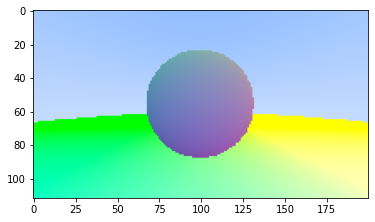

In [22]:
image = jnp.reshape(pixels, image_shape)
plt.imshow(image)

Lets see how much easier jax makes this! A reminder that our steps are: 
- Get the disciminant and roots of every ray with every circle
- Create a mask of valid intersections which are within our FOV
- Find the closest solution (i.e, the intersection on this side of a given sphere), this will require correcting the solutions by adding (2*max +1) to any invalid (but potentially closer) solutions
- Include background as a potential object to hit in the solutions and colors matrix
- Calculate the specific color depending on ray angle
- Calculate colors for each pixel by summing across objects and masking any objects not hit

In [24]:
# Get discrim and roots of all rays with a given sphere
def hit_sphere(center, radius, color, origin, direction):
    oc = origin - center # [1,3] - [1,3]
    a = jnp.sum(direction * direction, -1) #[N, 3], [N,3] -> [N] 
    b = 2 * jnp.sum(oc * direction,-1) # [1,3], [N,3] -> [N]
    c = jnp.sum(oc * oc, -1) - radius * radius # [1]
    discriminant = b*b - (4*a*c) # [N]
    sqrt_relu_discrim = jnp.sqrt(jax.nn.relu(discriminant)) # [N]
    r1 = (-b - sqrt_relu_discrim) / (2*a) # [N]
    r2 = (-b + sqrt_relu_discrim) / (2*a) # [N]

    # Whether it was hit
    hit = jnp.logical_and(discriminant >= 0 , jnp.logical_or(r1 > min_ray, r2 > min_ray)) #[N]

    # Where there isn't a hit (set the solutions to a point beyond any solution)
    r1 += jnp.logical_not(hit) * (2*max_ray + 1)
    r2 += jnp.logical_not(hit) * (2*max_ray + 1)

    distance = jnp.min(jnp.vstack([r1,r2]), 0)

    coord = origin + (direction * distance[:, jnp.newaxis]) # [1,3] + [N, 3] [N] -> [N, 3] # where is each one being hitting it's solution
    normal = (coord - center) / radius 

    color =  0.5*(normal + 1.0)                     
    return hit, distance, coord, normal, color

def select_color(distance, color, point, normal):
  '''
  distance: [1+O]
  color: [1+O, 3]
  point: [1+O, 3]
  normal: [1+O, 3]
  '''
  closest = jnp.argmin(distance)
  color, point, normal = color[closest], point[closest], normal[closest]
  return color, closest, point, normal

@jax.jit
def find_solutions(sphere_origin, sphere_radius, sphere_color, origin, direction):
  '''
  Sphere origin : [O, 3]
  Sphere radius : [O,1 ]
  Sphere color : [0,3]
  Origin: [3]
  Direction: [N, 3]

  ------------------

  pixels: [N, 3]
  did_hit: [N]
  closest: [N] (indicies)
  point: [N,3] (at intersection)
  normal: [N,3] (at intersection)
  '''

  # compute unit directions by dividing by norm
  unit_direction = direction / jnp.linalg.norm(direction, axis=-1)[:, jnp.newaxis]
  background_t = 0.5*(unit_direction[:,2]+1)[:, jnp.newaxis] # [N,1]
  background_color = (1-background_t) @ jnp.array([[1.0,1.0,1.0]]) + background_t @ jnp.array([[0.5, 0.7, 1.0]]) # [N,3]
  # for each circle, return: if it was hit, how far along the ray the hit was, what the coordinate of that is, and the normal at the point of impact
  # [O, N], [O, N], [O, N, 3], [O, N, 3]
  hit, distance, coord, normal, sphere_color = vmap(hit_sphere, in_axes = (0,0, 0, None, None))(sphere_origin, sphere_radius, sphere_color, origin, direction) 
  # combine these with the backgrounds
  distance = jnp.concatenate([valid_background_dist, distance], 0) # [1+O, N]
  all_colors = jnp.concatenate([background_color[:, jnp.newaxis, :], jnp.transpose(sphere_color, (1,0,2))], 1) # [N, 1+O, 3]


  # place our current origin and direction in as dummies for when the background is selected
  # this isn't used in returning the color, but just gives something to return when backgroun
  # is selected that won't give a degenerate solution.
  # this is used when we do multiple loops - but any of the sols where background is selected will
  # be masked so it doesn't _really_ matter what goes here.
  intersection_with_dummy = jnp.concatenate([jnp.tile(origin, (1, N, 1)), coord], 0) # [1+0, N, 3]
  normal_with_dummy = jnp.concatenate([direction[jnp.newaxis,:,:], normal], 0) # [1+O, N, 3]
  # choose the minimum - this is just a gather_nd, but I have to say its pretty simple to do it with vmap.
  pixels, closest, point, normal = vmap(select_color, in_axes = (1,0, 1,1))(distance, all_colors, intersection_with_dummy, normal_with_dummy) 

  solved = jnp.logical_not(jnp.max(hit, 0))
  return pixels, solved, closest, point, normal

  # 
  # return vmap(color)(discrim[0,:], unit_direction)

In [30]:
%%time
pixels, solved, closest, point, normal = find_solutions(spheres, radii, sphere_colors, origin, direction)

CPU times: user 2.73 ms, sys: 1.72 ms, total: 4.45 ms
Wall time: 9.01 ms


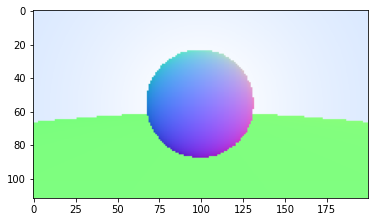

In [26]:
image = jnp.reshape(pixels, image_shape)
plt.imshow(image)

Great! It works, is simple and fast. 

Lets make a proper partial function for the camera so we can reposition it


In [36]:
from functools import partial

def unit(v):
    return v / jnp.linalg.norm(v, axis=-1)

# @jax.jit
def get_rays(lookfrom, lookat, uv, vup, viewport_width, viewport_height):
    '''
    Return ray directions for a given camera
    '''
    w = unit(lookfrom-lookat)
    u = unit(jnp.cross(vup, w))
    v = jnp.cross(w,u)

    origin = lookfrom
    horizontal = viewport_width * u
    vertical = viewport_height * v

    lower_left_corner = origin - horizontal / 2 - vertical /2 - w
    # multiply each u component with horizontal, and v compoent with vertical. 
    viewport_hv = jnp.vstack([horizontal, vertical])
    direction = lower_left_corner + uv @ viewport_hv - origin

    return direction

def create_camera(theta_deg = 120, aspect_ratio=16.0/9.0, vup=jnp.array([0,0,1]), image_width=200):
    '''
    Return a partial function which can be jitted and simply passed the current position and target of the camera, and will then return
    the current ray directions with minimal compute.
    '''
    theta = theta_deg * jnp.pi / 180
    h = jnp.tan(theta/2)
    viewport_height = 2 * h
    viewport_width = aspect_ratio * viewport_height
    image_height = jnp.array(image_width / aspect_ratio, int)

    # create the range of u and v values
    u = jnp.arange(0, image_width, 1) / (image_width-1)
    v = jnp.arange(0, image_height, 1)[::-1] / (image_height-1) # maybe remove the int() - it makes it identical to guide but doesn't give 01 range
    # construct a grid from them, and stretch it into two 1D vectos so that we have a long list of u,v points
    u, v = jnp.meshgrid(u,v)
    u, v = u.reshape([-1]), v.reshape([-1])

    uv = jnp.vstack([u,v]).T # [N,2] - pixel coords

    return partial(get_rays, uv=uv, vup=vup, viewport_width=viewport_width, viewport_height=viewport_height), jnp.array([image_height, image_width, 3]), image_height*image_width

In [37]:
camera, image_shape, N = create_camera(theta_deg=120, image_width = 400)

valid_background = jnp.ones([1,N]) # the background is always valid
valid_background_dist = valid_background*max_ray # and always max dist away

In [38]:
min_ray = 0.01 # don't render anything closer than 0.01m 
max_ray = 1000 # or further than 1000m

# make some spheres
spheres = jnp.array([[0,-1,0], [0,-1.0,-100.5]]) # [O, 3]
sphere_colors = jnp.array([[1.0, 0, 0], [0,1,1]]) # [O, 3]
radii = jnp.array([[0.5], [100]]) # [O, 1]
O = len(spheres)

In [39]:
origin = jnp.array([0,-0.35,0])

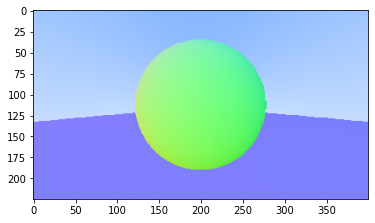

In [40]:
direction = camera(lookfrom = origin, lookat=jnp.array([0,-1,0]))
pixels, did_hit, closest, point, normal = find_solutions(spheres, radii, sphere_colors, origin, direction)
image = jnp.reshape(pixels, image_shape)
plt.imshow(image)

Our logic now changes. 

In an iterative ray tracing algo the logic goes

get_color()
   - if we hit something:
      return 0.5 * raycolor(new ray)
    if not:
      return background

Each ray will iterate a different number of times. I propose that instead we iterate some fixed number of times, using a scan function.

At each step, we should record if something was hit. If not, carry over prev color values. If so, mask and copy in new values. 


In [58]:
# Get discrim and roots of all rays with a given sphere
def hit_sphere(center, radius, color, origin, direction):
    oc = origin - center # [1,3] - [1,3]
    a = jnp.sum(direction * direction, -1) #[N, 3], [N,3] -> [N] 
    b = 2 * jnp.sum(oc * direction,-1) # [1,3], [N,3] -> [N]
    c = jnp.sum(oc * oc, -1) - radius * radius # [1]
    discriminant = b*b - (4*a*c) # [N]
    sqrt_relu_discrim = jnp.sqrt(jax.nn.relu(discriminant)) # [N]
    r1 = (-b - sqrt_relu_discrim) / (2*a) # [N]
    r2 = (-b + sqrt_relu_discrim) / (2*a) # [N]

    # Whether it was hit
    hit = jnp.logical_and(discriminant >= 0 , jnp.logical_or(r1 > min_ray, r2 > min_ray)) #[N]

    # Where there isn't a hit (set the solutions to a point beyond any solution)
    r1 += jnp.logical_not(hit) * (2*max_ray + 1)
    r2 += jnp.logical_not(hit) * (2*max_ray + 1)

    distance = jnp.min(jnp.vstack([r1,r2]), 0)

    coord = origin + (direction * distance[:, jnp.newaxis]) # [1,3] + [N, 3] [N] -> [N, 3] # where is each one being hitting it's solution
    normal = (coord - center) / radius 
    # print(color.shape)
    color =  jnp.tile(color, (N,1)) # 0.5*(normal + 1.0)                     
    return hit, distance, coord, normal, color

def select_color(distance, color, point, normal):
  '''
  distance: [1+O]
  color: [1+O, 3]
  point: [1+O, 3]
  normal: [1+O, 3]
  '''
  closest = jnp.argmin(distance)
  color, point, normal = color[closest], point[closest], normal[closest]
  return color, closest, point, normal

@jax.jit
def find_solutions(sphere_origin, sphere_radius, sphere_color, origin, direction):
  '''
  Sphere origin : [O, 3]
  Sphere radius : [O,1 ]
  Sphere color : [0,3]
  Origin: [N, 3]
  Direction: [N, 3]

  ------------------

  pixels: [N, 3]
  did_hit: [N]
  closest: [N] (indicies)
  point: [N,3] (at intersection)
  normal: [N,3] (at intersection)
  '''

  # compute unit directions by dividing by norm
  unit_direction = direction / jnp.linalg.norm(direction, axis=-1)[:, jnp.newaxis]
  background_t = 0.5*(unit_direction[:,2]+1)[:, jnp.newaxis] # [N,1]
  background_color = (1-background_t) @ jnp.array([[1.0,1.0,1.0]]) + background_t @ jnp.array([[0.5, 0.7, 1.0]]) # [N,3]
  # for each circle, return: if it was hit, how far along the ray the hit was, what the coordinate of that is, and the normal at the point of impact
  # [O, N], [O, N], [O, N, 3], [O, N, 3]
  hit, distance, coord, normal, sphere_color = vmap(hit_sphere, in_axes = (0,0, 0, None, None))(sphere_origin, sphere_radius, sphere_color, origin, direction) 
  # combine these with the backgrounds
  distance = jnp.concatenate([valid_background_dist, distance], 0) # [1+O, N]
  all_colors = jnp.concatenate([background_color[:, jnp.newaxis, :], jnp.transpose(sphere_color, (1,0,2))], 1) # [N, 1+O, 3]


  # place our current origin and direction in as dummies for when the background is selected
  # this isn't used in returning the color, but just gives something to return when backgroun
  # is selected that won't give a degenerate solution.
  # this is used when we do multiple loops - but any of the sols where background is selected will
  # be masked so it doesn't _really_ matter what goes here.
  intersection_with_dummy = jnp.concatenate([origin[jnp.newaxis, :, :], coord], 0) # [1+0, N, 3]
  normal_with_dummy = jnp.concatenate([direction[jnp.newaxis,:,:], normal], 0) # [1+O, N, 3]
  # choose the minimum - this is just a gather_nd, but I have to say its pretty simple to do it with vmap.
  pixels, closest, point, normal = vmap(select_color, in_axes = (1,0, 1,1))(distance, all_colors, intersection_with_dummy, normal_with_dummy) 

  solved = jnp.logical_not(jnp.max(hit, 0))
  return pixels, solved, closest, point, normal

In [219]:

from jax import random
key = random.PRNGKey(0)

color = jnp.zeros([N,3])

for j in range(0,5):

  prev_solved = jnp.zeros([N,1])

  origin = jnp.tile(jnp.array([[0,-0.35,0]]), [N,1])
  direction = camera(lookfrom = origin[0], lookat=jnp.array([0,-1,0]))


  scatter = jax.random.uniform(key, [N, 3])*0.01

  phi = jax.random.uniform(key, [N]) * 2 * jnp.pi
  costheta = (jax.random.uniform(key, [N]) - 0.5) * 2
  u = jax.random.uniform(key, [N])

  theta = jnp.arccos(costheta)
  r = 1 * jnp.power(u, 1/3)

  x = r * jnp.sin(theta) * jnp.cos(phi)
  y = r * jnp.sin(theta) * jnp.sin(phi)
  z = r * jnp.cos(theta)

  rd = jnp.vstack([x,y,z]).T

  end = 5
  for i in range(0, end):
    _, key = random.split(key)
    # main issue we're looking to resolve is the rays will go all weird when they _dont_ hit anything. 
    # we want if it hit an obect, which we will mask if it has already dissapeared off into the distance. 
    pixels, now_solved, closest, origin, direction = find_solutions(spheres, radii, sphere_colors, origin, direction+scatter)

    # this is a cheap operation, but inaccurate
    # bounce = jax.random.normal(key, [N, 3])*0.6
    # bounce /= jnp.linalg.norm(bounce, -1)


    direction += rd *0.7


    # When don't we want to take the color from here? Only when it was previously solved. 
    color = ((pixels * jnp.logical_not(prev_solved)) * 0.5**i) + color * prev_solved

    # now recompute
    prev_solved = jnp.logical_or(prev_solved, now_solved[:, jnp.newaxis]) #

    if i == end-2:
       prev_solved = jnp.ones([N,1])
    # image = jnp.reshape(prev_solved, image_shape[:2])
    # plt.imshow(image)
    # plt.show()

  

# For anything still not solved, give it a 0 - darkness. 

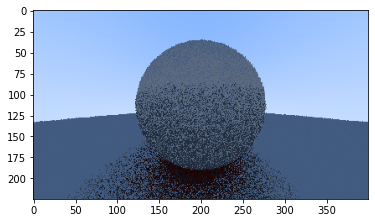

In [220]:
image = jnp.reshape(color, image_shape)
plt.imshow(image)

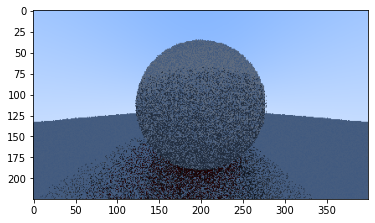

In [202]:
image = jnp.reshape(color, image_shape)
plt.imshow(image)

Little bit more complicated now if we want surface normals. We have to know where it hit, not just if it hit. 

To test lets make a few assumptions
- One sphere in front of us, so if there are roots then we can take the negative
-  

In [25]:
sphere_origin = jnp.array([[0,0,-1]])
sphere_radius = jnp.array([[0.5]])


def hit_sphere(center, radius, origin, direction):
    oc = origin - center # [1,3] - [1,3]
    a = jnp.sum(direction * direction, -1) #[N, 3], [N,3] -> [N] 
    b = 2 * jnp.sum(oc * direction,-1) # [N]
    c = jnp.sum(oc * oc, -1) - radius * radius
    discriminant = b*b - (4*a*c)
    # this vector tells us whether or not it was it (i.e 0 or 1)
    no_hit = discriminant < 0

    return 

def sphere(unit_direction):
    return jnp.array([1.0,0,0])

@jax.jit
def bg_unvec(unit_direction):
    t = 0.5*(unit_direction[1] +1.0) # [N,1]
    colors = (1-t) * jnp.array([1.0,1.0,1.0]) + t*jnp.array([0.5, 0.7, 1.0]) # [N,1] @ [1, 3] + [N,1] @ [1,3] -> [N,3]
    return colors

@jax.jit
def color(discrim, unit_direction):
    return jax.lax.cond(discrim, sphere, bg_unvec, unit_direction)

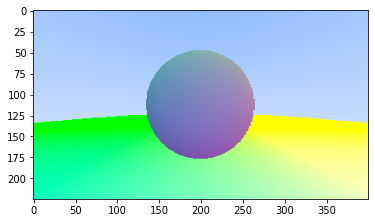

In [315]:
background_color

DeviceArray([[0.6399489 , 0.78396934, 1.        ],
             [0.6396102 , 0.7837661 , 1.        ],
             [0.63927007, 0.78356206, 1.        ],
             ...,
             [0.8603158 , 0.9161895 , 1.        ],
             [0.8603158 , 0.9161895 , 1.        ],
             [0.85978824, 0.91587293, 1.        ]], dtype=float32)

In [350]:
spheres_tiled = jnp.tile(spheres[jnp.newaxis,:,:], [N, 1,1])

(1440000, 2, 3)

In [44]:
%%time
x= test_color(unit_direction)

CPU times: user 2.8 ms, sys: 97 µs, total: 2.9 ms
Wall time: 5.28 ms


In [36]:
unit_direction

DeviceArray([[-0.78258556,  0.44020438, -0.44020438],
             [-0.78105766,  0.4415592 , -0.4415592 ],
             [-0.7795155 ,  0.44291964, -0.44291964],
             ...,
             [ 0.78139186, -0.44126335, -0.44126335],
             [ 0.78139186, -0.44126335, -0.44126335],
             [ 0.78376615, -0.43915302, -0.43915302]], dtype=float32)

In [324]:
%%time
discrim = hit_sphere(sphere_origin, sphere_radius, origin, direction)

CPU times: user 534 µs, sys: 1.57 ms, total: 2.11 ms
Wall time: 3.65 ms


In [285]:
sphere_origin = jnp.array([0,0,-10])
sphere_radius = 1
oc = origin[0] - sphere_origin
a = jnp.dot(direction[0], direction[0])
b = 2 * jnp.dot(oc, direction[0])
c = jnp.dot(oc, oc) - sphere_radius * sphere_radius
discriminant = b*b - 4*a*c
discriminant

DeviceArray(-1643.5555, dtype=float32)

DeviceArray([[False, False, False, ..., False, False, False]], dtype=bool)

DeviceArray([2.1600754, 1.7657671, 1.4442774, 1.2529705, 1.2529676,
             1.4479527, 1.7657574, 2.1657946, 2.0445707, 1.6224295,
             1.2650218, 1.0412867, 1.0412835, 1.2692165, 1.6224186,
             2.0506117, 2.0844965, 1.6724632, 1.3285842, 1.1176467,
             1.1176437, 1.3325788, 1.6724529, 2.090422 , 2.271672 ,
             1.9006581, 1.6063949, 1.4368378, 1.4368354, 1.6097004,
             1.9006491, 2.2771108], dtype=float32)

DeviceArray([[-1.7777778 ,  0.7109375 , -1.        ],
             [-1.2698432 ,  0.7109375 , -1.        ],
             [-0.76190865,  0.7109375 , -1.        ],
             [-0.25397408,  0.7109375 , -1.        ],
             [ 0.2539605 ,  0.7109375 , -1.        ],
             [ 0.76885307,  0.7109375 , -1.        ],
             [ 1.2698296 ,  0.7109375 , -1.        ],
             [ 1.7847222 ,  0.7109375 , -1.        ],
             [-1.7777778 ,  0.140625  , -1.        ],
             [-1.2698432 ,  0.140625  , -1.        ],
             [-0.76190865,  0.140625  , -1.        ],
             [-0.25397408,  0.140625  , -1.        ],
             [ 0.2539605 ,  0.140625  , -1.        ],
             [ 0.76885307,  0.140625  , -1.        ],
             [ 1.2698296 ,  0.140625  , -1.        ],
             [ 1.7847222 ,  0.140625  , -1.        ],
             [-1.7777778 , -0.4296875 , -1.        ],
             [-1.2698432 , -0.4296875 , -1.        ],
             [-0.76190865, -

In [39]:
@flax.struct.dataclass
class Pixel:
  """Contains data for one environment pixel."""
  pixels: jnp.ndarray

In [ ]:
def compute_pixel(carry, unused_target_t):
    i,j = carry
    act = jp.ones((batch_size, env.action_size,)) * jp.sin(i * jp.pi / 15)
    nstate = jit_env_step(state, act)
    i += 1
    return (nstate, i), StepData(state, act)

state = env.reset(rng=jp.random_prngkey(seed=0))

%%time
(state, i), data = jax.lax.scan(take_step, (state, 0), (), 100) # may need to run twice to see speedups

ವಿದಾಯ! 👋